In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
num_train=mnist.train.num_examples
num_val=mnist.validation.images.shape
num_test=mnist.test.images.shape

In [3]:
batch_size=64
img_size=28
RNN_unit=img_size*img_size
N_watch=10

In [4]:
tf.reset_default_graph()
X=tf.placeholder(dtype=tf.float32,shape=[None,img_size*img_size])
y=tf.placeholder(dtype=tf.int64,shape=[None,10])

predict_net=tf.layers.Dense(units=10)

def get_next_input(output, i):
    attention_weight=tf.nn.softmax(output)
    weighted_graph=X*attention_weight
    return weighted_graph

lstm_cell = tf.nn.rnn_cell.LSTMCell(RNN_unit, state_is_tuple=True)
init_state = lstm_cell.zero_state(batch_size, tf.float32)

inputs=[X]
inputs.extend([0]*N_watch)
outputs,_ = tf.contrib.legacy_seq2seq.rnn_decoder(inputs, init_state, lstm_cell, loop_function=get_next_input)

output=outputs[-1]
score=predict_net(output)

predictions = tf.argmax(score, 1)
correct_predictions = tf.equal(predictions, tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"))

loss=tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score)
optimizier=tf.train.AdamOptimizer(learning_rate=1e-5)
train_step = optimizier.minimize(loss)

In [5]:
max_epoch=50
print_every=200

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        loss_num,_ = sess.run([loss,train_step],feed_dict={X:images,y:labels})
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'current training loss = %f' % (loss_num))
            
def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images,y:labels})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy
    
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]
    
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'start epoch %d/%d:' % (epoch+1,max_epoch))
        train()
        loss_train,acc_train=eval(mnist.train,2000)
        loss_val,acc_val=eval(mnist.validation,500)
        loss_test,acc_test=eval(mnist.test,1000)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))

2018-04-13 16:51:12 start epoch 1/50:
2018-04-13 16:51:12 iteration 1/859: current training loss = 2.301888
2018-04-13 16:51:14 iteration 200/859: current training loss = 1.914014
2018-04-13 16:51:16 iteration 400/859: current training loss = 0.965600
2018-04-13 16:51:18 iteration 600/859: current training loss = 0.820855
2018-04-13 16:51:20 iteration 800/859: current training loss = 0.303383
2018-04-13 16:51:21 iteration 859/859: current training loss = 0.561343
2018-04-13 16:51:36 end epoch 1/50: acc_train=84.823% acc_val=85.453% acc_test=85.469%
2018-04-13 16:51:36 start epoch 2/50:
2018-04-13 16:51:36 iteration 1/859: current training loss = 0.330166
2018-04-13 16:51:38 iteration 200/859: current training loss = 0.483591
2018-04-13 16:51:40 iteration 400/859: current training loss = 0.373152
2018-04-13 16:51:42 iteration 600/859: current training loss = 0.546122
2018-04-13 16:51:43 iteration 800/859: current training loss = 0.378881
2018-04-13 16:51:44 iteration 859/859: current tr

2018-04-13 16:56:43 end epoch 15/50: acc_train=96.810% acc_val=96.194% acc_test=95.964%
2018-04-13 16:56:43 start epoch 16/50:
2018-04-13 16:56:43 iteration 1/859: current training loss = 0.090527
2018-04-13 16:56:45 iteration 200/859: current training loss = 0.073734
2018-04-13 16:56:47 iteration 400/859: current training loss = 0.100326
2018-04-13 16:56:49 iteration 600/859: current training loss = 0.261580
2018-04-13 16:56:51 iteration 800/859: current training loss = 0.286364
2018-04-13 16:56:52 iteration 859/859: current training loss = 0.127040
2018-04-13 16:57:04 end epoch 16/50: acc_train=96.996% acc_val=96.213% acc_test=96.231%
2018-04-13 16:57:04 start epoch 17/50:
2018-04-13 16:57:04 iteration 1/859: current training loss = 0.115799
2018-04-13 16:57:06 iteration 200/859: current training loss = 0.180109
2018-04-13 16:57:08 iteration 400/859: current training loss = 0.066585
2018-04-13 16:57:09 iteration 600/859: current training loss = 0.056087
2018-04-13 16:57:11 iteration 

2018-04-13 17:01:37 iteration 800/859: current training loss = 0.108231
2018-04-13 17:01:37 iteration 859/859: current training loss = 0.070917
2018-04-13 17:01:50 end epoch 30/50: acc_train=98.468% acc_val=97.278% acc_test=96.791%
2018-04-13 17:01:50 start epoch 31/50:
2018-04-13 17:01:50 iteration 1/859: current training loss = 0.017432
2018-04-13 17:01:52 iteration 200/859: current training loss = 0.108070
2018-04-13 17:01:54 iteration 400/859: current training loss = 0.065203
2018-04-13 17:01:56 iteration 600/859: current training loss = 0.071679
2018-04-13 17:01:58 iteration 800/859: current training loss = 0.058605
2018-04-13 17:01:59 iteration 859/859: current training loss = 0.013860
2018-04-13 17:02:12 end epoch 31/50: acc_train=98.312% acc_val=97.172% acc_test=96.873%
2018-04-13 17:02:12 start epoch 32/50:
2018-04-13 17:02:12 iteration 1/859: current training loss = 0.072733
2018-04-13 17:02:14 iteration 200/859: current training loss = 0.020371
2018-04-13 17:02:16 iteration 

2018-04-13 17:06:49 iteration 400/859: current training loss = 0.030285
2018-04-13 17:06:52 iteration 600/859: current training loss = 0.009039
2018-04-13 17:06:53 iteration 800/859: current training loss = 0.003283
2018-04-13 17:06:54 iteration 859/859: current training loss = 0.014403
2018-04-13 17:07:08 end epoch 45/50: acc_train=99.016% acc_val=97.597% acc_test=97.078%
2018-04-13 17:07:08 start epoch 46/50:
2018-04-13 17:07:08 iteration 1/859: current training loss = 0.011757
2018-04-13 17:07:10 iteration 200/859: current training loss = 0.021205
2018-04-13 17:07:12 iteration 400/859: current training loss = 0.090930
2018-04-13 17:07:14 iteration 600/859: current training loss = 0.038537
2018-04-13 17:07:16 iteration 800/859: current training loss = 0.019416
2018-04-13 17:07:16 iteration 859/859: current training loss = 0.083729
2018-04-13 17:07:30 end epoch 46/50: acc_train=99.335% acc_val=97.456% acc_test=97.256%
2018-04-13 17:07:30 start epoch 47/50:
2018-04-13 17:07:30 iteratio

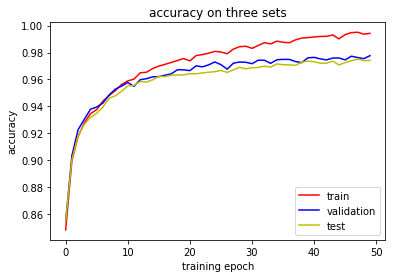

In [6]:
plt.figure(2)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()